# Building a Llama 2 chatbot with Retrieval Augmented Generation (RAG)

This notebook shows a complete example of how to build a Llama 2 chatbot hosted on your browser that can answer questions based on your own data. We'll cover:
* How to run Llama2 in the cloud hosted on OctoAI
* A chatbot example built with [Gradio](https://github.com/gradio-app/gradio) and wired to the server
* Adding RAG capability with Llama 2 specific knowledge based on our Getting Started [guide](https://ai.meta.com/llama/get-started/)


**Note** We will be using OctoAI to run the examples here. You will need to first sign into [OctoAI](https://octoai.cloud/) with your Github or Google account, then create a free API token [here](https://octo.ai/docs/getting-started/how-to-create-an-octoai-access-token) that you can use for a while (a month or $10 in OctoAI credits, whichever one runs out first).
After the free trial ends, you will need to enter billing info to continue to use Llama2 hosted on OctoAI.

## RAG Architecture

LLMs have unprecedented capabilities in NLU (Natural Language Understanding) & NLG (Natural Language Generation), but they have a knowledge cutoff date, and are only trained on publicly available data before that date.

RAG, invented by [Meta](https://ai.meta.com/blog/retrieval-augmented-generation-streamlining-the-creation-of-intelligent-natural-language-processing-models/) in 2020, is one of the most popular methods to augment LLMs. RAG allows enterprises to keep sensitive data on-prem and get more relevant answers from generic models without fine-tuning models for specific roles.

RAG is a method that:
* Retrieves data from outside a foundation model
* Augments your questions or prompts to LLMs by adding the retrieved relevant data as context
* Allows LLMs to answer questions about your own data, or data not publicly available when LLMs were trained
* Greatly reduces the hallucination in  model's response generation

The following diagram shows the general RAG components and process:

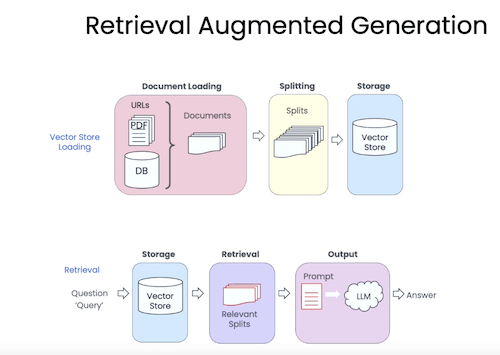

## How to Develop a RAG Powered Llama 2 Chatbot

The easiest way to develop RAG-powered Llama 2 chatbots is to use frameworks such as [**LangChain**](https://www.langchain.com/) and [**LlamaIndex**](https://www.llamaindex.ai/), two leading open-source frameworks for building LLM apps. Both offer convenient APIs for implementing RAG with Llama 2 including:

* Load and split documents
* Embed and store document splits
* Retrieve the relevant context based on the user query
* Call Llama 2 with query and context to generate the answer

LangChain is a more general purpose and flexible framework for developing LLM apps with RAG capabilities, while LlamaIndex as a data framework focuses on connecting custom data sources to LLMs. The integration of the two may provide the best performant and effective solution to building real world RAG apps.
In our example, for simplicifty, we will use LangChain alone with locally stored PDF data.

### Install Dependencies

For this demo, we will be using the Gradio for chatbot UI, Text-generation-inference framework for model serving.
For vector storage and similarity search, we will be using [FAISS](https://github.com/facebookresearch/faiss).
In this example, we will be running everything in a AWS EC2 instance (i.e. [g5.2xlarge]( https://aws.amazon.com/ec2/instance-types/g5/)). g5.2xlarge features one A10G GPU. We recommend running this notebook with at least one GPU equivalent to A10G with at least 16GB video memory.
There are certain techniques to downsize the Llama 2 7B model, so it can fit into smaller GPUs. But it is out of scope here.

First, let's install all dependencies with PIP. We also recommend you start a dedicated Conda environment for better package management.

And let's set up the OctoAI token.

In [ ]:
!pip install -r requirements.txt

In [ ]:
from getpass import getpass
import os

OCTOAI_API_TOKEN = getpass()
os.environ["OCTOAI_API_TOKEN"] = OCTOAI_API_TOKEN

### Data Processing

First run all the imports and define the path of the data and vector storage after processing.
For the data, we will be using a raw pdf crawled from Llama 2 Getting Started guide on [Meta AI website](https://ai.meta.com/llama/).

In [ ]:
from langchain.embeddings import OctoAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

DATA_PATH = 'data' #Your root data folder path
DB_FAISS_PATH = 'vectorstore/db_faiss'

Then we use the `PyPDFDirectoryLoader` to load the entire directory. You can also use `PyPDFLoader` for loading one single file.

In [ ]:
loader = PyPDFDirectoryLoader(DATA_PATH)
documents = loader.load()

Check the length and content of the doc to ensure we have loaded the right document with number of pages as 37.

In [ ]:
print(len(documents), documents[0].page_content[0:100])

Split the loaded documents into smaller chunks.
[`RecursiveCharacterTextSplitter`](https://api.python.langchain.com/en/latest/text_splitter/langchain.text_splitter.RecursiveCharacterTextSplitter.html) is one common splitter that splits long pieces of text into smaller, semantically meaningful chunks.
Other splitters include:
* SpacyTextSplitter
* NLTKTextSplitter
* SentenceTransformersTokenTextSplitter
* CharacterTextSplitter

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=10)
splits = text_splitter.split_documents(documents)
print(len(splits), splits[0])

Note that we have set `chunk_size` to 500 and `chunk_overlap` to 10. In the spliting, these two parameters can directly affects the quality of the LLM's answers.
Here is a good [guide](https://dev.to/peterabel/what-chunk-size-and-chunk-overlap-should-you-use-4338) on how you should carefully set these two parameters.

Next we will need to choose an embedding model for our splited documents.
**Embeddings are numerial representations of text**. The default embedding model in OctoAI Embeddings is GTE-Large with a 1024 vector length.

In [ ]:
embeddings = OctoAIEmbeddings(endpoint_url="https://text.octoai.run/v1/embeddings")

Lastly, with splits and choice of the embedding model ready, we want to index them and store all the split chunks as embeddings into the vector storage.

Vector stores are databases storing embeddings. There're at least 60 [vector stores](https://python.langchain.com/docs/integrations/vectorstores) supported by LangChain, and two of the most popular open source ones are:
* [Chroma](https://www.trychroma.com/): a light-weight and in memory so it's easy to get started with and use for **local development**.
* [FAISS](https://python.langchain.com/docs/integrations/vectorstores/faiss) (Facebook AI Similarity Search): a vector store that supports search in vectors that may not fit in RAM and is appropriate for **production use**.

Since we are running on a EC2 instance with abundant CPU resources and RAM, we will use FAISS in this example. Note that FAISS can also run on GPUs, where some of the most useful algorithms are implemented there. In that case, install `faiss-gpu` package with PIP instead.

In [ ]:
db = FAISS.from_documents(splits, embeddings)
db.save_local(DB_FAISS_PATH)

Once you saved database into local path. You can find them as `index.faiss` and `index.pkl`. In the chatbot example, you can then load this database from local and plug it into our retrival process.

### Building the Chatbot UI

Now we are ready to build the chatbot UI to wire up RAG data and API server. In our example we will be using Gradio to build the Chatbot UI.
Gradio is an open-source Python library that is used to build machine learning and data science demos and web applications. It has been widely used by the community. Other alternatives are:
* [Streamlit](https://streamlit.io/)
* [Dash](https://plotly.com/dash/)
* [Flask](https://flask.palletsprojects.com/en/3.0.x/)

Again, we start by adding all the imports, paths, constants and set LangChain in debug mode, so it shows clear actions within the chain process.

In [ ]:
import langchain
from queue import Queue
from typing import Any
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.schema import LLMResult
from langchain.embeddings import OctoAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA
from langchain.prompts.prompt import PromptTemplate
from anyio.from_thread import start_blocking_portal #For model callback streaming

# langchain.debug=True

#vector db path
DB_FAISS_PATH = 'vectorstore/db_faiss'

model_dict = {
    "13-chat" : "llama-2-13b-chat-fp16",
    "70b-chat" : "llama-2-70b-chat-fp16",
}

system_message = {"role": "system", "content": "You are a helpful assistant."}

Then we load the FAISS vector store

In [ ]:
embeddings = OctoAIEmbeddings(endpoint_url="https://text.octoai.run/v1/embeddings")
db = FAISS.load_local(DB_FAISS_PATH, embeddings)

Next we call the Llama 2 model from OctoAI. In this example we will use the Llama 2 13b chat FP16 model. You can find more on Llama 2 models on the [OctoAI text generation solution page](https://octoai.cloud/tools/text).

At the time of writing this notebook the following Llama models are available on OctoAI:
* llama-2-13b-chat
* llama-2-70b-chat
* codellama-7b-instruct
* codellama-13b-instruct
* codellama-34b-instruct
* codellama-70b-instruct

In [ ]:
from langchain.llms.octoai_endpoint import OctoAIEndpoint

llama2_13b = "llama-2-13b-chat-fp16"
llm = OctoAIEndpoint(
    endpoint_url="https://text.octoai.run/v1/chat/completions",
    model_kwargs={
        "model": llama2_13b,
        "messages": [system_message],
        "max_tokens": 500,
        "top_p": 1,
        "temperature": 0.01
    },
)

Next, we define the retriever and template for our RetrivalQA chain. For each call of the RetrievalQA, LangChain performs a semantic similarity search of the query in the vector database, then passes the search results as the context to Llama to answer the query about the data stored in the verctor database.
Whereas for the template, this defines the format of the question along with context that we will be sent into Llama for generation. In general, Llama 2 has special prompt format to handle special tokens. In some cases, the serving framework might already have taken care of it. Otherwise, you will need to write customized template to properly handle that.

In [ ]:
template = """
[INST]Use the following pieces of context to answer the question. If no context provided, answer like a AI assistant.
{context}
Question: {question} [/INST]
"""

retriever = db.as_retriever(
        search_kwargs={"k": 6}
    )

Lastly, we can define the retrieval chain for QA

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type_kwargs={
        "prompt": PromptTemplate(
            template=template,
            input_variables=["context", "question"],
        ),
    }
)

Now we should have a working chain for QA. Let's test it out before wire it up with UI blocks.

In [ ]:
result = qa_chain.invoke({"query": "Why choose Llama?"})
print(result["result"])

After confirming the validity, we can start building the UI. We'll use a simple interface built out of Gradio's ChatInterface.

In [ ]:
import gradio as gr

def predict(message, history):
    llm_response = qa_chain.invoke(message)["result"]
    return llm_response

gr.ChatInterface(predict).launch()